In [ ]:
import time
import datetime
import pickle
import random

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import transformers

from torch.utils.data import random_split
from collections import defaultdict
from transformers import BertForMaskedLM, BertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup

device = 'cuda:0'
softmax = torch.nn.Softmax(dim=-1)
torch.manual_seed(0)
np.random.seed(0)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
device = torch.device('cuda:0')
model.to(device)

In [ ]:
# here we are adding 3 groups of new tokens:
# * group 1 will be trained for target degree modification (3 subgroups for low/middle/high)
# * group 2 will be trained with randomly shuffled degree modification contexts
# * group 3 will be kept untrained

mod_indicies = []
for tok in range(99):
    tokenizer.add_tokens([f'[mod{tok%3}_{tok}]'])
    mod_indicies.append( tokenizer(f'[mod{tok%3}_{tok}]')['input_ids'][1:-1][0] )
rand_mod_indicies = []
for tok in range(99):
    tokenizer.add_tokens([f'[modR_{tok}]'])
    rand_mod_indicies.append( tokenizer(f'[modR_{tok}]')['input_ids'][1:-1][0] )
untrained_mod_indicies = []    
for tok in range(99):
    tokenizer.add_tokens([f'[modU_{tok}]'])
    untrained_mod_indicies.append( tokenizer(f'[modU_{tok}]')['input_ids'][1:-1][0] )

model.resize_token_embeddings(len(tokenizer))

reverse_vocab = {y:x for x, y in tokenizer.vocab.items()}
for x,y in tokenizer.get_added_vocab().items():
    reverse_vocab[y] = x

In [ ]:
# we will use prepared artificial sentences
pos_neg = []
for neg, pos in zip(open('10k_neg.txt', encoding='utf-8'), open('10k_aff.txt', encoding='utf-8')):
    pos_neg.append( (pos.strip(), neg.strip()) )
    
ten_k = pd.read_csv('modifiers_all.csv',index_col=0).head(10000)

genders = pickle.load( open( "noun_genders.pkl", "rb" ) )

In [ ]:
# we also will use these special particles to 
# (we automatically mined them previously based on well known degree modifiers)

low_helpers = ['well', 'actually', 'now', 'but', 'however', 'still', 'so', 'why', 'anyway', 'sure']
high_helpers = ['yes', 'oh', 'sir', 'absolutely', 'god', 'damn', 'remember', 'wow', 'seriously', 'man']

In [ ]:
def _process(sentence, tokenizer, model):
    sentence = sentence.replace('[mask]', '[MASK]')
    tokens = tokenizer.tokenize(sentence)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    segment_ids = [0] * len(tokens)
    n = tokens.index('[MASK]')

    input_ids = torch.tensor([input_ids,], dtype=torch.long).to(device)
    segment_ids = torch.tensor([segment_ids,], dtype=torch.long).to(device)
    
    logits = model(input_ids, token_type_ids=segment_ids)[0]
    probs = softmax(logits)

    return probs[0][n].cpu().detach().numpy()

def new_mod_preds(mod_index, pos_neg, tokenizer, model, dbg=False):
    result = defaultdict(list)
    
    for idx,(pos, neg)  in enumerate(pos_neg):
        preds_aff = _process(pos.lower(), tokenizer, model)
        preds_neg = _process(neg.lower(), tokenizer, model)
        for i, m_idx in enumerate(mod_index):
            diff = preds_aff[m_idx].item() - preds_neg[m_idx].item()
            result[i].append(diff)
        if dbg and idx and not idx % 1000:
            print( np.mean(np.array(list(result.values())), axis=1)[:10] )
    return result

def evaluate_polarity(mod_index, pos_neg, tokenizer, model):
    result = new_mod_preds(mod_index, pos_neg, tokenizer, model)
    rr = np.array(list(result.values()))
#     print( np.count_nonzero(rr>0.,axis=1)/rr.shape[1] )
    return np.count_nonzero(rr>0.,axis=1)/rr.shape[1]

In [ ]:
# first we will evaluate polarity of new untrained tokens to make sure it is random in each of groups

In [ ]:
random_embs_polarity = evaluate_polarity(mod_indicies, pos_neg, tokenizer, model)
plt.hist(random_embs_polarity)
plt.show()

In [ ]:
random_embs_polarity2 = evaluate_polarity(rand_mod_indicies, pos_neg, tokenizer, model)
plt.hist(random_embs_polarity2)
plt.show()

In [ ]:
random_embs_polarity3 = evaluate_polarity(untrained_mod_indicies, pos_neg, tokenizer, model)
plt.hist(random_embs_polarity3)
plt.show()

In [ ]:
# next we will evaluate the degree modification property of our new tokens 
# (again, it supposed to be random)

def assess_batch(texts):
    batch_input_ids = []
    batch_segment_ids = []
    n_pos = []
    for sentence in texts:
        sentence = sentence.replace('[mask]', '[MASK]')
        tokens = tokenizer.tokenize(sentence)
        tokens = ["[CLS]"] + tokens + ["[SEP]"]
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        segment_ids = [0] * len(tokens)
        n = tokens.index('[MASK]')
        n_pos.append( n )
        batch_input_ids.append( input_ids )
        batch_segment_ids.append( segment_ids )

    input_ids = torch.tensor(batch_input_ids, dtype=torch.long).to(device)
    segment_ids = torch.tensor(batch_segment_ids, dtype=torch.long).to(device)
    logits = model(input_ids, token_type_ids=segment_ids)[0]
    probs = softmax(logits)
    
    res = []
    for n, probs_item in zip(n_pos, probs):
        res.append( probs_item[n].cpu().detach().numpy() )
    return res

assess_modifiers_indicies = mod_indicies[:]
assess_modifiers_indicies.extend( rand_mod_indicies[:] )
assess_modifiers_indicies.extend( untrained_mod_indicies[:] )
assess_modifiers_indicies.append( tokenizer.vocab['somewhat'] )
assess_modifiers_indicies.append( tokenizer.vocab['very'] )

degree_mod_scores = defaultdict(int)

for idx,(id,row) in enumerate(ten_k.iterrows()):
    if idx%19: continue # we don't need the full data, it's enought to use a subsample
    words = row['sentence'].split(' ')
    adjective = words[3].rstrip('.')
    noun = words[1]
    copula = words[2]
    sents = []
    for h in low_helpers+high_helpers:
        if copula == 'is':
            sent = f'Is the {noun} {adjective}? {h}, {genders[noun]} is [MASK] {adjective}.'
        else:
            sent = f'Are the {noun} {adjective}? {h}, {genders[noun]} are [MASK] {adjective}.'
        sents.append( sent.lower() )

    batch_probs = assess_batch( sents )

    helpers1 = list(range(10))
    helpers2 = list(range(10,20))
    np.random.shuffle(helpers1)
    np.random.shuffle(helpers2)        

    for c in assess_modifiers_indicies:
        for h1,h2 in zip(helpers1,helpers2):
            degree_mod_scores['_total_'] += 1
            if batch_probs[h1][c]<batch_probs[h2][c]:
                degree_mod_scores[reverse_vocab[c]] += 1

tt = degree_mod_scores['_total_']/len(assess_modifiers_indicies)

random_embs_dmod = []        
for m in mod_indicies:
    random_embs_dmod.append( degree_mod_scores[reverse_vocab[m]]/tt )
random_embs_dmod2 = []        
for m in rand_mod_indicies:
    random_embs_dmod2.append( degree_mod_scores[reverse_vocab[m]]/tt )
random_embs_dmod3 = []        
for m in untrained_mod_indicies:
    random_embs_dmod3.append( degree_mod_scores[reverse_vocab[m]]/tt )

In [ ]:
plt.hist(random_embs_dmod)
plt.show()

In [ ]:
plt.hist(random_embs_dmod2)
plt.show()

In [ ]:
plt.hist(random_embs_dmod3)
plt.show()

In [ ]:
# let's check it together -- polarity and degree modifying properties

plt.scatter(random_embs_dmod3, random_embs_polarity3)
plt.xlabel('degree', fontsize=18)
plt.ylabel('polarity', fontsize=18)
plt.show()

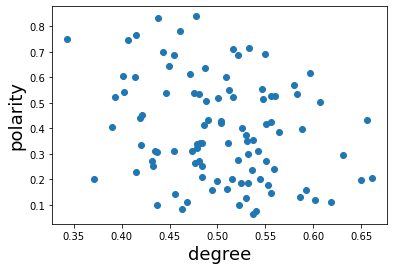

## Moving on to training

In [ ]:
# again, we will use 3 groups of particles to enforce contexts for the different levels of degree modifying property

v1 = ['alternatively', 'myself', 'similarly', 'accordingly', 'otherwise', 'however', 'alternately', 'likewise', 'conversely', 'er', 'although', 'thus', 'nevertheless', 'nonetheless', 'still', 'hence']
v2 = ['yes', 'once', 'naturally', 'evidently', 'eventually', 'not', 'surely', 'nowadays', 'however', 'someday', 'fortunately', 'here', 'presumably', 'ideally', 'accordingly', 'hopefully']
v3 = ['god', 'gods', 'goddess', 'dammit', 'christ', 'goddamn', 'jesus', 'fucking', 'holy', 'kate', 'damn', 'skyla', 'lord', 'princess', 'love', 'daddy']

# fixed contexts for subgroups of the group 1
vvv = [v1,v2,v3]

# mixed contexts for the group 2
vvvv = v1+v2+v3

In [ ]:
# compile the training sentences using the selected particles for subgroups of the group 1

sentences_v1 = []
sentences_v2 = []
sentences_v3 = []

for idx,(id,row) in enumerate(ten_k.iterrows()):
    words = row['sentence'].lower().split(' ')
    adjective = words[3].rstrip('.')
    noun = words[1]
    copula = words[2]
    if not idx%1000:
        print(idx, words)
    for tok in range(99):
        my_tok = f'[mod{tok%3}_{tok}]'
        helper = vvv[tok%3][np.random.randint(0,len(vvv[tok%3]))]
        if copula == 'is':
            sent = f'is the {noun} {adjective}? {helper}, {genders[noun]} is {my_tok} {adjective}.'
        else:
            sent = f'are the {noun} {adjective}? {helper}, {genders[noun]} are {my_tok} {adjective}.'
        if tok%3==0:
            sentences_v1.append(sent)
        elif tok%3==1:
            sentences_v2.append(sent)
        else:
            sentences_v3.append(sent)
    if not idx%1000:
        print(idx, sent)

In [ ]:
# compile sentences with mixed contexts for the group 2

sentences_v4 = []
for idx,(id,row) in enumerate(ten_k.iterrows()):
    words = row['sentence'].lower().split(' ')
    adjective = words[3].rstrip('.')
    noun = words[1]
    copula = words[2]
    if not idx%1000:
        print(idx, words)
        
    for tok in range(99):
        my_tok = f'[modR_{tok}]'
        helper = vvvv[np.random.randint(0,len(vvvv))]
        if copula == 'is':
            sent = f'is the {noun} {adjective}? {helper}, {genders[noun]} is {my_tok} {adjective}.'
        else:
            sent = f'are the {noun} {adjective}? {helper}, {genders[noun]} are {my_tok} {adjective}.'
        sentences_v4.append(sent)
    if not idx%1000:
        print(idx, sent)

### Preparing data for MLM training

In [ ]:
all_sentences = sentences_v1 + sentences_v2 + sentences_v3 + sentences_v4
len(all_sentences)
np.random.shuffle(all_sentences)
print(all_sentences[:10])

In [ ]:
print(len(all_sentences))
inputs = tokenizer(all_sentences, return_tensors='pt', max_length=64, truncation=True, padding='max_length')

In [ ]:
inputs['labels'] = inputs.input_ids.detach().clone()

#### masking

In [ ]:
rand = torch.rand(inputs.input_ids.shape)
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * (inputs.input_ids != 102) * (inputs.input_ids != 0)

In [ ]:
selection = []

for i in range(inputs.input_ids.shape[0]):
    selection.append(
        torch.flatten(mask_arr[i].nonzero()).tolist()
    )
for i in range(inputs.input_ids.shape[0]):
    inputs.input_ids[i, selection[i]] = 103

In [ ]:
class MLMDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
dataset = MLMDataset(inputs)

In [ ]:
model.train()

#### optimizer and its parameters

In [ ]:
from transformers import AdamW

for i,param in enumerate(model.parameters()):
    if i not in [0,]: # 198,199]:
        param.requires_grad = False
optim = AdamW(model.parameters(), lr=5e-5)

In [ ]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [ ]:
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optim, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value again all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        print('batch loss:',loss.item())
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optim.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.5f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.5f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.5f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    model.save_pretrained(f'BertDegree_epoch{epoch_i}')
    
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
model.save_pretrained(f'BertDegree3_epoch{epoch_i}')

In [ ]:
# now we re-evaluate polarity of our tokens

epoch03_embs_polarity1 = evaluate_polarity(mod_indicies, pos_neg, tokenizer, model)
epoch03_embs_polarity2 = evaluate_polarity(rand_mod_indicies, pos_neg, tokenizer, model)
epoch03_embs_polarity3 = evaluate_polarity(untrained_mod_indicies, pos_neg, tokenizer, model)

In [ ]:
# also we re-evaluate degree modifying properties of our tokens

degree_mod_scores_after = defaultdict(int)
for idx,(id,row) in enumerate(ten_k.iterrows()):
    if idx%19: continue # we don't need the full data, it's enought to use a subsample
    words = row['sentence'].split(' ')
    adjective = words[3].rstrip('.')
    noun = words[1]
    copula = words[2]
    sents = []
    for h in low_helpers+high_helpers:
        if copula == 'is':
            sent = f'Is the {noun} {adjective}? {h}, {genders[noun]} is [MASK] {adjective}.'
        else:
            sent = f'Are the {noun} {adjective}? {h}, {genders[noun]} are [MASK] {adjective}.'
        sents.append( sent.lower() )

    batch_probs = assess_batch( sents )

    helpers1 = list(range(10))
    helpers2 = list(range(10,20))
    np.random.shuffle(helpers1)
    np.random.shuffle(helpers2)        

    for c in assess_modifiers_indicies:
        for h1,h2 in zip(helpers1,helpers2):
            degree_mod_scores_after['_total_'] += 1
            if batch_probs[h1][c]<batch_probs[h2][c]:
                degree_mod_scores_after[reverse_vocab[c]] += 1


In [ ]:
tt = degree_mod_scores_after['_total_']/len(assess_modifiers_indicies)

epoch03_embs_dmod = []        
for m in mod_indicies:
    epoch03_embs_dmod.append( degree_mod_scores_after[reverse_vocab[m]]/tt )
epoch03_embs_dmod2 = []        
for m in rand_mod_indicies:
    epoch03_embs_dmod2.append( degree_mod_scores_after[reverse_vocab[m]]/tt )
epoch03_embs_dmod3 = []        
for m in untrained_mod_indicies:
    epoch03_embs_dmod3.append( degree_mod_scores_after[reverse_vocab[m]]/tt )

In [ ]:
# draw the resulting properties of tokens from subgroups of the group 1

plt.scatter(epoch03_embs_dmod[::3],  epoch03_embs_polarity1[::3], c='r', label='v1', alpha=0.3)
plt.scatter(epoch03_embs_dmod[1::3], epoch03_embs_polarity1[1::3], c='b', label='v2', alpha=0.3)
plt.scatter(epoch03_embs_dmod[2::3], epoch03_embs_polarity1[2::3], c='g', label='v3', alpha=0.3)
plt.legend()
plt.xlabel('degree', fontsize=18)
plt.ylabel('polarity', fontsize=18)
plt.show()

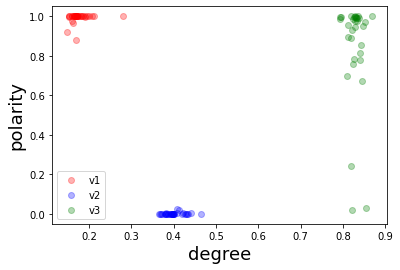

In [ ]:
# for the sanity check -- same for the group 2

plt.scatter(epoch03_embs_dmod2, epoch03_embs_polarity2, c='k', label='v1', alpha=0.3)
plt.xlabel('degree', fontsize=18)
plt.ylabel('polarity', fontsize=18)
plt.show()

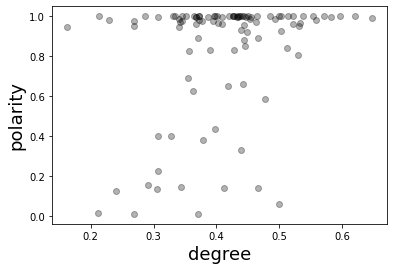

In [ ]:
with open('results.tsv', 'w', encoding='utf-8') as ofh:
    print('group\ttoken\tdmod_before_learning\tpolarity_before_learning\tdmod_after_learning\tpolarity_after_learning', file=ofh)
    for i, t_idx in enumerate(mod_indicies):
        sgroup = {
            0:'train_low_degree',
            1:'train_middle_degree',
            2:'train_high_degree',
        }[i%3]
        print(f'{sgroup}\t{reverse_vocab[t_idx]}\t{random_embs_dmod[i]:0.4f}\t{random_embs_polarity[i]:0.4f}\t{epoch03_embs_dmod[i]:0.4f}\t{epoch03_embs_polarity1[i]:0.4f}', file=ofh)

    for i, t_idx in enumerate(rand_mod_indicies):
        sgroup = 'random_degree'
        print(f'{sgroup}\t{reverse_vocab[t_idx]}\t{random_embs_dmod2[i]:0.4f}\t{random_embs_polarity2[i]:0.4f}\t{epoch03_embs_dmod2[i]:0.4f}\t{epoch03_embs_polarity2[i]:0.4f}', file=ofh)

    for i, t_idx in enumerate(untrained_mod_indicies):
        sgroup = 'untrained'
        print(f'{sgroup}\t{reverse_vocab[t_idx]}\t{random_embs_dmod3[i]:0.4f}\t{random_embs_polarity3[i]:0.4f}\t{epoch03_embs_dmod3[i]:0.4f}\t{epoch03_embs_polarity3[i]:0.4f}', file=ofh)
